In [2]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## Functions

In [3]:
# read a folder of images and turn them into an array

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array) - 1): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks

def zoom_at(image_array, zoom, coord=None):
    
    zoomed_array = []
    
    for img in image_array: 
        

        # Translate to zoomed coordinates
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array

def double_crop(image_array): 
    
    cropped_images = []
    
    for image in image_array: 
        
        # this is crop for each side (totalCrop/2) 
        cropped_image = image[0:515, 70:570]
        
        cropped_images.append(cropped_image)
    
    return cropped_images

def add_padding(image_array): 
    
    padded_images = []
    
    for image in image_array: 

        padded_image = cv2.copyMakeBorder(
            image,
            17,
            17,
            0,
            0,
            cv2.BORDER_CONSTANT,
            value=(255,255,255)
        )
        
        padded_images.append(padded_image)
        
    return padded_images


In [4]:
# function to resize images

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images 

In [5]:
# function to create blank masks 

def create_blank_masks(image_array): 
    masks = []
    for i in range(len(image_array)): 
        mask = np.zeros((256, 256), dtype=np.uint8)  # Create a 2D array filled with zeros
        masks.append(mask)
    return masks

In [6]:
# get bounding box, if its empty, then create a random sized bounding box  

def get_bounding_box(image_mask):
    
    if np.all(image_mask == 0):
        # If all zeros, create a random bounding box
        H, W = image_mask.shape
        x_min = np.random.randint(0, W)
        x_max = np.random.randint(x_min + 1, W + 1)  # Ensure x_max > x_min
        y_min = np.random.randint(0, H)
        y_max = np.random.randint(y_min + 1, H + 1)  # Ensure y_max > y_min
        
        bbox = [x_min, y_min, x_max, y_max]
    else: 
        if len(image_mask.shape) == 2 or image_mask.shape[2] == 1:
            gray = image_mask
        else:
            gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return (0, 0, 0, 0)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        bbox = [x, y, x+w, y+h]
    
    return bbox

## Apply Functions

In [7]:
# get images
folder_path_training = './data/training_images'
train_images = read_images_to_array(folder_path_training)
folder_path_val = './data/val_images'
val_images = read_images_to_array(folder_path_val)
folder_path_empty = './data/images_wo_tumor'
ntumor_images = read_images_to_array(folder_path_empty)

# split them 
train_masks, train_raw = split_images(train_images)
val_masks, val_raw = split_images(val_images) 

# crop each one out 
train_raw = crop_raw_images(train_raw) 
val_raw = crop_raw_images(val_raw) 
train_masks = crop_masks(train_masks)
val_masks = crop_masks(val_masks) 

# create masks for images with no tumors 
ntumor_masks = create_blank_masks(ntumor_images) 

# zoom masks
train_masks = zoom_at(train_masks, 1.4, coord=None)
val_masks = zoom_at(val_masks, 1.4, coord=None)

# create binary masks
train_masks = create_binary_masks(train_masks)
val_masks = create_binary_masks(val_masks) 

# crop raw images 
train_raw = double_crop(train_raw)
val_raw = double_crop(val_raw) 

# add padding to raw images 
train_raw = add_padding(train_raw) 
val_raw = add_padding(val_raw) 

# resize images to 256x256 
train_raw = crop_images(train_raw) 
train_masks = crop_images(train_masks) 

val_raw = crop_images(val_raw) 
val_masks = crop_images(val_masks) 

ntumor_images = crop_images(ntumor_images) 
ntumor_masks = crop_images(ntumor_masks) 

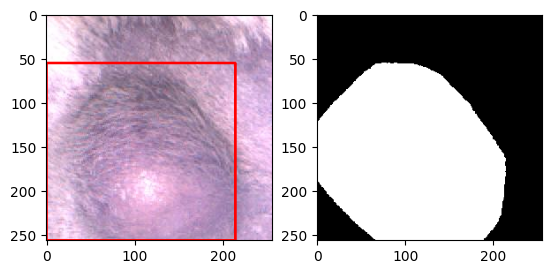

In [15]:
# Test bounding box function
rand = random.randint(0, len(train_raw) - 1)

# Get the bounding box for the selected mask
bbox = get_bounding_box(train_masks[rand])

# Plot the images
fig, ax = plt.subplots(1, 2)

# Create a copy of the raw image to draw the rectangle on
copy_image = train_raw[rand].copy()

# Draw the bounding box on the image
cv2.rectangle(copy_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

# Display the images
ax[0].imshow(copy_image)
ax[1].imshow(train_masks[rand], cmap="gray")
plt.show()


In [8]:
train_masks = np.array(train_masks)
train_raw = np.array(train_raw) 

val_masks = np.array(val_masks)
val_raw = np.array(val_raw) 

print(train_masks.shape)
print(train_raw.shape)
print(val_masks.shape)
print(val_raw.shape) 

(153, 256, 256)
(153, 256, 256, 3)
(36, 256, 256)
(36, 256, 256, 3)


## Augmentation

In [9]:
# Augmentation function 

def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
            for i in range(len(image_array_raw) -1):
                image_raw = image_array_raw[i]
                image_binary = image_array_binary[i]

                flipped_image_raw = cv2.flip(image_raw, 1)
                flipped_image_binary = cv2.flip(image_binary, 1)

                # Random angle
                angle = random.uniform(-30, 30)
                (h, w) = flipped_image_raw.shape[:2]
                center = (w // 2, h // 2)

                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
                augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

                aug_raw.append(augmented_image_raw)
                aug_masks.append(augmented_image_binary)

    # Extend original arrays with augmented data
    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

In [10]:
# apply augmentation to all images

train_raw, train_masks = augment_image_array(train_raw, train_masks, 100) 
val_raw, val_masks = augment_image_array(val_raw, val_masks, 100) 
ntumor_images, ntumor_masks = augment_image_array(ntumor_images, ntumor_masks, 50)

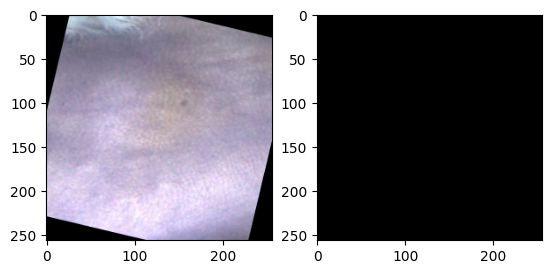

In [11]:
# test no tumor images

rand = random.randint(0, len(ntumor_images) -1) 

fig, ax = plt.subplots(1,2) 

ax[0].imshow(ntumor_images[rand])
ax[1].imshow(ntumor_masks[rand], cmap="gray")

plt.show()

In [12]:
print(train_raw.shape)
print(train_masks.shape) 
print(val_raw.shape) 
print(val_masks.shape) 

print(ntumor_images.shape)
print(ntumor_masks.shape)

(15353, 256, 256, 3)
(15353, 256, 256)
(3536, 256, 256, 3)
(3536, 256, 256)
(2041, 256, 256, 3)
(2041, 256, 256)


In [13]:
# now add them to the orignal arrays 
train_raw = np.concatenate((train_raw, ntumor_images), axis=0)
train_masks = np.concatenate((train_masks, ntumor_masks), axis=0)

In [14]:
print(train_raw.shape)
print(train_masks.shape) 

(17394, 256, 256, 3)
(17394, 256, 256)


## Create the Dataset

In [15]:
# now create a dataset with these images

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_raw],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_raw],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [16]:
print(len(val_dataset_dict["image"]))
print(len(val_dataset_dict["label"]))

print(len(training_dataset_dict["image"]))
print(len(training_dataset_dict["label"]))

3536
3536
17394
17394


In [17]:
# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [18]:
# check that everythings working

# now to check that everything is working 

# picks a random image and displays it

rand_train = random.randint(0, len(training_raw) - 1) 
rand_val = random.randint(0, len(val_raw) - 1) 

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(training_dataset["label"][rand_train], cmap = "gray")
ax[0].set_title('Binary Mask (training)')

ax[1].imshow(training_dataset["image"][rand_train])
ax[1].set_title('Raw Image (training)')

ax[2].imshow(val_dataset["label"][rand_val], cmap ="gray") 
ax[2].set_title("Binary Mask (validation)") 

ax[3].imshow(val_dataset["image"][rand_val]) 
ax[3].set_title("Raw Image (validation)")

# Hide axis ticks and labels
for axe in ax:
    axe.set_xticks([])
    axe.set_yticks([])
    axe.set_xticklabels([])
    axe.set_yticklabels([])

# Display the images side by side
plt.show()

NameError: name 'training_raw' is not defined

In [19]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [20]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [21]:
from torch.utils.data import random_split, DataLoader

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)


train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

In [22]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

## Train the model

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./models/mito_model_checkpoint6.pth")

100%|██████████| 8697/8697 [38:16<00:00,  3.79it/s]


EPOCH: 0
Mean training loss: -152518511.2452075


100%|██████████| 1768/1768 [07:25<00:00,  3.97it/s]


Mean validation loss: -382028477.98190045


 16%|█▋        | 1416/8697 [06:14<32:18,  3.76it/s]